# Import Semua Packages/Library yang Digunakan

In [1]:
# Libraries umum
import shutil
import zipfile
import random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Visualisasi
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Pemrosesan data gambar
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback,
    EarlyStopping,
    ReduceLROnPlateau,
)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

2025-09-24 05:26:09.745106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758691569.965838      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758691570.028908      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [4]:
ROOT_PATH = '/kaggle/input/food11-image-dataset'
training_path = f'{ROOT_PATH}/training'
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

In [5]:
from PIL import Image
import os

def print_images_resolution(directory):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue  # skip file non-folder

        unique_sizes = set()
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except:
                print(f"⚠️ gagal buka: {img_path}")

        print("Ukuran unik:")
        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal semua gambar: {total_images}")

# Pakai path yang benar di Kaggle
ROOT_PATH = '/kaggle/input/food11-image-dataset'

training_path   = f'{ROOT_PATH}/training'
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

# Jalankan fungsi untuk cek dataset
print("=== Training ===")
print_images_resolution(training_path)

print("\n=== Validation ===")
print_images_resolution(validation_path)

print("\n=== Evaluation ===")
print_images_resolution(evaluation_path)

=== Training ===
Fried food: 848
Ukuran unik:
- (512, 342)
- (506, 512)
- (512, 287)
- (341, 512)
- (385, 512)
- (512, 473)
- (512, 436)
- (288, 512)
- (512, 384)
- (510, 512)
- (512, 509)
- (512, 506)
- (512, 512)
- (382, 512)
- (512, 341)
- (512, 344)
- (512, 289)
- (512, 362)
- (426, 512)
- (505, 512)
- (307, 512)
- (384, 512)
- (512, 371)
- (512, 380)
- (512, 499)
- (289, 512)
- (512, 383)
- (512, 334)
- (302, 512)
- (512, 511)
- (512, 398)
- (512, 401)
- (512, 340)
- (512, 410)
- (512, 288)
- (511, 512)
- (512, 306)
- (512, 309)
- (306, 512)
- (512, 498)
- (512, 324)
- (512, 382)
- (512, 385)
- (512, 510)
- (512, 339)
---------------
Noodles-Pasta: 440
Ukuran unik:
- (512, 342)
- (512, 287)
- (508, 512)
- (640, 515)
- (600, 360)
- (512, 308)
- (397, 300)
- (288, 512)
- (512, 314)
- (512, 384)
- (510, 512)
- (512, 509)
- (512, 512)
- (382, 512)
- (800, 534)
- (450, 534)
- (600, 448)
- (512, 341)
- (475, 356)
- (512, 289)
- (512, 391)
- (600, 356)
- (600, 487)
- (512, 307)
- (384, 5

In [6]:
import os
from collections import defaultdict

data_dir = ROOT_PATH
label_counts = defaultdict(int)
total_images = 0

# Iterate through the subdirectories (training, validation, evaluation)
for split_dir in os.listdir(data_dir):
    split_dir_path = os.path.join(data_dir, split_dir)
    if os.path.isdir(split_dir_path):
        # Iterate through the label directories within each split directory
        for label_dir in os.listdir(split_dir_path):
            label_dir_path = os.path.join(split_dir_path, label_dir)
            if os.path.isdir(label_dir_path):
                num_images = len(os.listdir(label_dir_path))
                label_counts[label_dir] += num_images
                total_images += num_images

print("Jumlah gambar per label:")
for label, count in label_counts.items():
    percentage = (count / total_images) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

print(f"\nTotal semua gambar: {total_images}")

Jumlah gambar per label:
- Fried food: 1461 (8.78%)
- Noodles-Pasta: 734 (4.41%)
- Bread: 1724 (10.36%)
- Dessert: 2500 (15.02%)
- Seafood: 1505 (9.04%)
- Soup: 2500 (15.02%)
- Meat: 2206 (13.25%)
- Dairy product: 721 (4.33%)
- Vegetable-Fruit: 1172 (7.04%)
- Egg: 1648 (9.90%)
- Rice: 472 (2.84%)

Total semua gambar: 16643


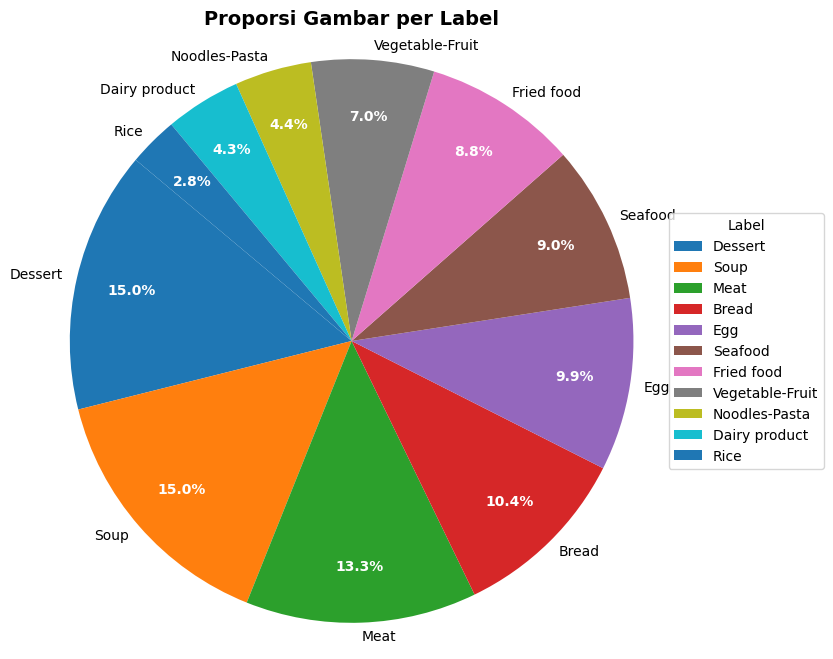

In [7]:
# Sort label biar dari terbesar ke terkecil
labels = list(label_counts.keys())
sizes = list(label_counts.values())
labels, sizes = zip(*sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(8, 8))

# Pie chart dengan pengaturan jarak
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10},
    pctdistance=0.8,    # posisi angka %
    labeldistance=1.05  # posisi label
)

# Buat teks % lebih tebal dan kontras
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.axis('equal')  
plt.title('Proporsi Gambar per Label', fontsize=14, fontweight='bold')

# Tambah legend di samping (opsional kalau label panjang)
plt.legend(wedges, labels, title="Label", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [8]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, size):
    """
    Mengubah ukuran semua gambar dalam direktori dan menyimpannya di direktori baru.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for split_dir in os.listdir(input_dir):
        split_dir_path = os.path.join(input_dir, split_dir)
        output_split_dir_path = os.path.join(output_dir, split_dir)

        if os.path.isdir(split_dir_path):
            if not os.path.exists(output_split_dir_path):
                os.makedirs(output_split_dir_path)

            for label_dir in os.listdir(split_dir_path):
                label_dir_path = os.path.join(split_dir_path, label_dir)
                output_label_dir_path = os.path.join(output_split_dir_path, label_dir)

                if os.path.isdir(label_dir_path):
                    if not os.path.exists(output_label_dir_path):
                        os.makedirs(output_label_dir_path)

                    image_files = os.listdir(label_dir_path)
                    print(f"Memproses {split_dir}/{label_dir}...")

                    for img_file in image_files:
                        img_path = os.path.join(label_dir_path, img_file)
                        output_img_path = os.path.join(output_label_dir_path, img_file)

                        try:
                            with Image.open(img_path) as img:
                                img_resized = img.resize(size)
                                img_resized.save(output_img_path)
                        except Exception as e:
                            print(f"⚠️ Gagal memproses {img_path}: {e}")

# Path di Kaggle
input_directory = ROOT_PATH 
output_directory = '/kaggle/working/food11-resized'
target_size = (224, 224)

# Jalankan resize
resize_images(input_directory, output_directory, target_size)

# Cek hasilnya
print("\nHasil tersimpan di:", output_directory)
print("Subfolder:", os.listdir(output_directory))

Memproses validation/Fried food...
Memproses validation/Noodles-Pasta...
Memproses validation/Bread...
Memproses validation/Dessert...
Memproses validation/Seafood...
Memproses validation/Soup...
Memproses validation/Meat...
Memproses validation/Dairy product...
Memproses validation/Vegetable-Fruit...
Memproses validation/Egg...
Memproses validation/Rice...
Memproses training/Fried food...
Memproses training/Noodles-Pasta...
Memproses training/Bread...
Memproses training/Dessert...
Memproses training/Seafood...
Memproses training/Soup...
Memproses training/Meat...
Memproses training/Dairy product...
Memproses training/Vegetable-Fruit...
Memproses training/Egg...
Memproses training/Rice...
Memproses evaluation/Fried food...
Memproses evaluation/Noodles-Pasta...
Memproses evaluation/Bread...
Memproses evaluation/Dessert...
Memproses evaluation/Seafood...
Memproses evaluation/Soup...
Memproses evaluation/Meat...
Memproses evaluation/Dairy product...
Memproses evaluation/Vegetable-Fruit...

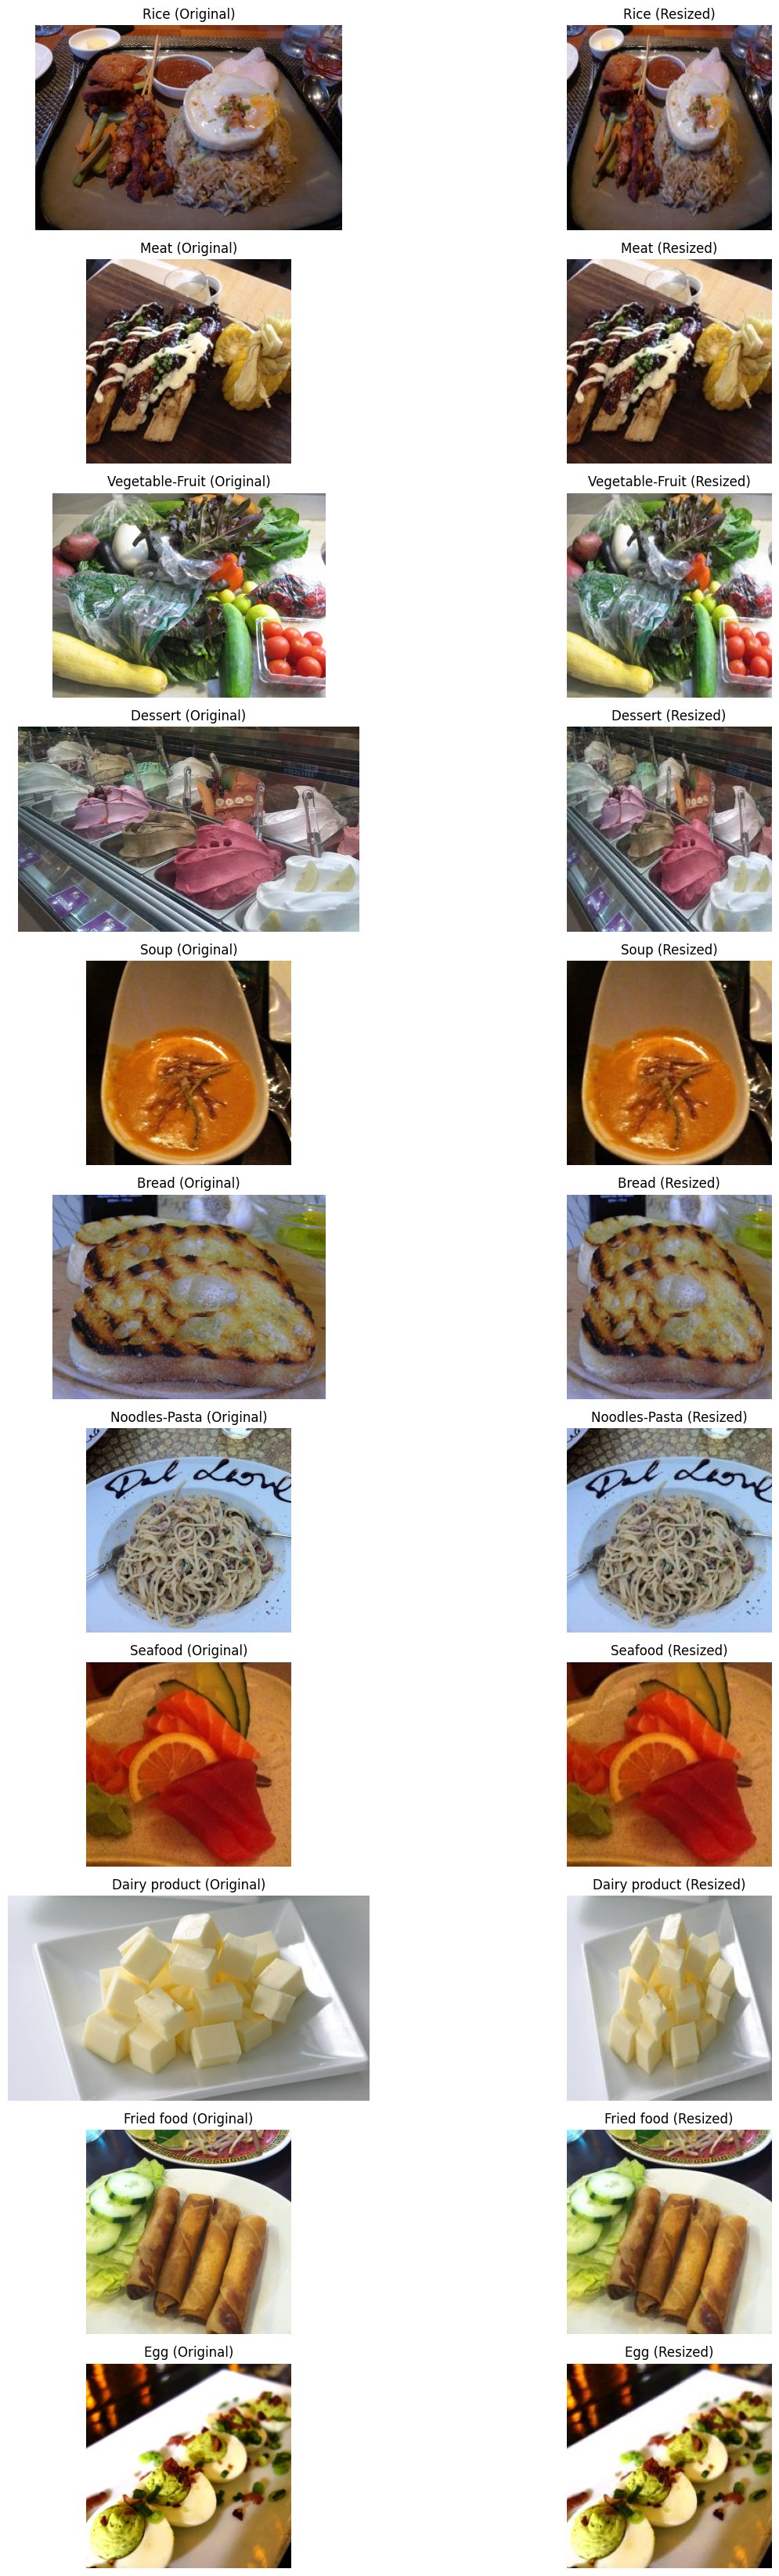

Jumlah gambar per set data setelah resize:
- evaluation: 3347 (20.11%)
- validation: 3430 (20.61%)
- training: 9866 (59.28%)

Total semua gambar di semua set: 16643


In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Direktori dataset asli (input) dan yang sudah di-resize (working)
original_dir = '/kaggle/input/food11-image-dataset/training'
resized_dir = '/kaggle/working/food11-resized/training'

# Dapatkan daftar semua labels (nama sub-direktori)
labels = os.listdir(resized_dir)
labels = [label for label in labels if os.path.isdir(os.path.join(resized_dir, label))] # Filter hanya direktori

# Tentukan berapa banyak contoh gambar per label yang ingin ditampilkan
num_examples_per_label = 1

# Sesuaikan ukuran figure untuk menampilkan dua kolom (asli dan resized)
plt.figure(figsize=(15, len(labels) * 3))

for i, label in enumerate(labels):
    original_label_dir = os.path.join(original_dir, label)
    resized_label_dir = os.path.join(resized_dir, label)

    # Pastikan direktori label ada di kedua lokasi
    if not os.path.isdir(original_label_dir) or not os.path.isdir(resized_label_dir):
        print(f"⚠️ Direktori label {label} tidak ditemukan di kedua lokasi.")
        continue

    image_files = os.listdir(resized_label_dir) # Ambil nama file dari direktori resized
    # Ambil beberapa contoh gambar secara acak
    sample_images = random.sample(image_files, min(num_examples_per_label, len(image_files)))

    for j, img_file in enumerate(sample_images):
        original_img_path = os.path.join(original_label_dir, img_file)
        resized_img_path = os.path.join(resized_label_dir, img_file)

        # Tampilkan gambar asli
        try:
            img_original = Image.open(original_img_path)
            plt.subplot(len(labels), num_examples_per_label * 2, i * num_examples_per_label * 2 + j * 2 + 1)
            plt.imshow(img_original)
            plt.title(f'{label} (Original)')
            plt.axis('off')
        except Exception as e:
            print(f"⚠️ Gagal menampilkan gambar asli {original_img_path}: {e}")

        # Tampilkan gambar yang sudah di-resize
        try:
            img_resized = Image.open(resized_img_path)
            plt.subplot(len(labels), num_examples_per_label * 2, i * num_examples_per_label * 2 + j * 2 + 2)
            plt.imshow(img_resized)
            plt.title(f'{label} (Resized)')
            plt.axis('off')
        except Exception as e:
            print(f"⚠️ Gagal menampilkan gambar resized {resized_img_path}: {e}")

plt.tight_layout()
plt.show()

# Check total images after resize
data_dir = '/kaggle/working/food11-resized' # Use the resized data directory
split_counts = {}
total_images_all_splits = 0

# Iterate through the split directories (training, validation, evaluation)
for split_dir in os.listdir(data_dir):
    split_dir_path = os.path.join(data_dir, split_dir)
    if os.path.isdir(split_dir_path):
        num_images_in_split = 0
        # Iterate through the label directories within each split directory
        for label_dir in os.listdir(split_dir_path):
            label_dir_path = os.path.join(split_dir_path, label_dir)
            if os.path.isdir(label_dir_path):
                num_images_in_split += len(os.listdir(label_dir_path))
        split_counts[split_dir] = num_images_in_split
        total_images_all_splits += num_images_in_split

print("Jumlah gambar per set data setelah resize:")
for split, count in split_counts.items():
    percentage = (count / total_images_all_splits) * 100
    print(f"- {split}: {count} ({percentage:.2f}%)")

print(f"\nTotal semua gambar di semua set: {total_images_all_splits}")

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisikan path untuk training, validation, dan evaluation data
train_dir = '/kaggle/working/food11-resized/training'
validation_dir = '/kaggle/working/food11-resized/validation'
evaluation_dir = '/kaggle/working/food11-resized/evaluation'

# Definisikan parameter untuk generator
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16

# Buat instance ImageDataGenerator untuk normalisasi
# Rescale 1./255 akan menskalakan nilai piksel dari [0, 255] menjadi [0, 1]
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,           # Rotasi gambar hingga 40 derajat
    width_shift_range=0.3,       # Pergeseran horizontal hingga 30%
    height_shift_range=0.3,      # Pergeseran vertikal hingga 30%
    shear_range=0.3,             # Transformasi geser
    zoom_range=0.3,              # Zoom hingga 30%
    horizontal_flip=True,        # Pembalikan horizontal acak
    brightness_range=[0.7, 1.3], # Variasi kecerahan
    fill_mode='nearest',         # Mode pengisian untuk area baru
    channel_shift_range=0.2      # Perubahan channel warna
)

# Validation dan evaluation hanya menggunakan normalisasi (tidak ada augmentasi)
validation_datagen = ImageDataGenerator(rescale=1./255)
evaluation_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator untuk data training, validation, dan evaluation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Karena ini adalah klasifikasi multikelas
    shuffle=True,              # Acak urutan data saat pelatihan
    seed=42                    # Untuk reproduktifitas
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,             # Tidak diacak untuk evaluasi yang konsisten
    seed=42
)

evaluation_generator = evaluation_datagen.flow_from_directory(
    evaluation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nNormalisasi data selesai dan generator telah dibuat.")
print(f"Jumlah kelas: {train_generator.num_classes}")
print(f"Jumlah batch training: {len(train_generator)}")
print(f"Jumlah batch validation: {len(validation_generator)}")
print(f"Jumlah batch evaluation: {len(evaluation_generator)}")

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.

Normalisasi data selesai dan generator telah dibuat.
Jumlah kelas: 11
Jumlah batch training: 617
Jumlah batch validation: 215
Jumlah batch evaluation: 210


In [11]:
# Menampilkan informasi tentang kelas
class_labels = list(train_generator.class_indices.keys())
print(f"Kelas yang tersedia: {class_labels}")

Kelas yang tersedia: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


Contoh hasil augmentasi data training:


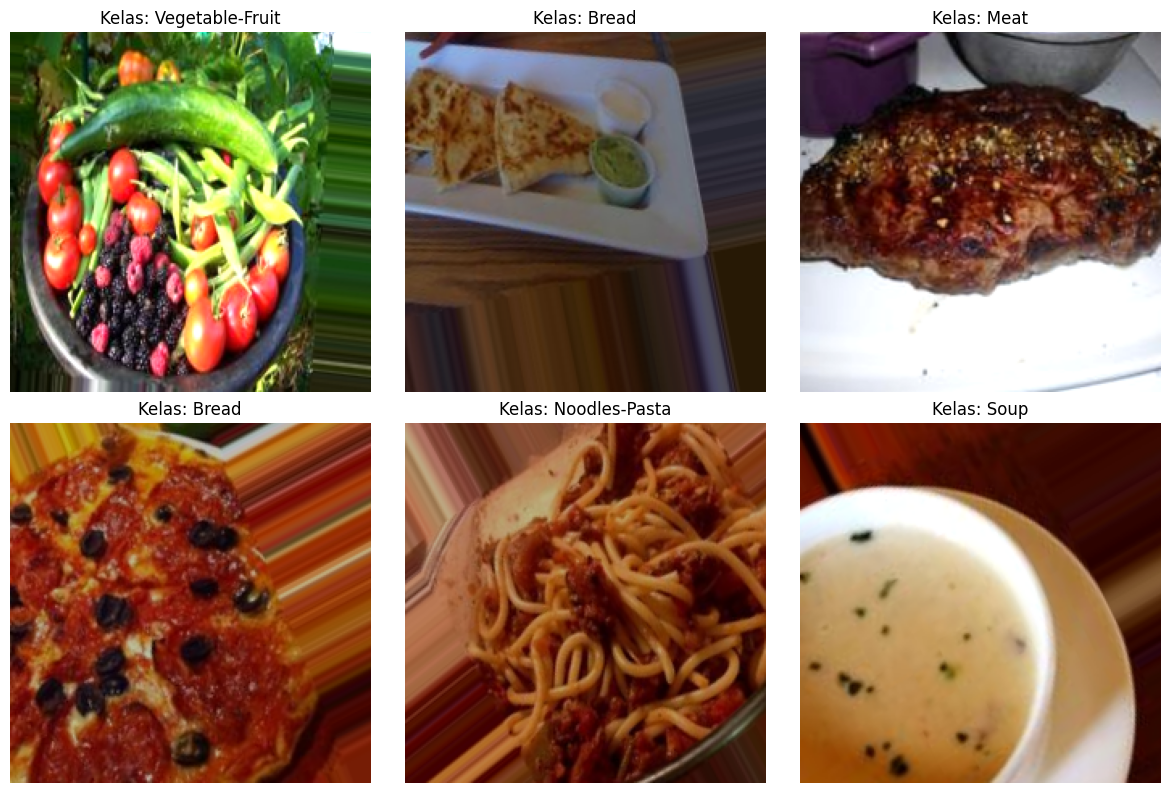

In [12]:
# Visualisasi beberapa contoh data augmentasi dari training generator
def visualize_augmentation(generator, num_samples=6):
    """
    Visualisasi contoh hasil augmentasi data
    """
    # Ambil satu batch dari generator
    batch = next(generator)
    images, labels = batch
    
    # Plot gambar
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # Kembalikan normalisasi untuk visualisasi
        img = images[i]
        # Jika gambar sudah dinormalisasi ke [0,1], gunakan langsung
        axes[i].imshow(img)
        # Dapatkan label asli
        label_idx = np.argmax(labels[i])
        label_name = class_labels[label_idx]
        axes[i].set_title(f'Kelas: {label_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualisasi augmentasi data training
print("Contoh hasil augmentasi data training:")
visualize_augmentation(train_generator)

In [13]:
# Cek bentuk data dari generator
sample_batch = next(train_generator)
print(f"Bentuk gambar batch: {sample_batch[0].shape}")
print(f"Bentuk label batch: {sample_batch[1].shape}")
print(f"Nilai piksel min: {sample_batch[0].min():.3f}, max: {sample_batch[0].max():.3f}")

# Kembalikan generator ke posisi awal
train_generator.reset()
validation_generator.reset()
evaluation_generator.reset()

Bentuk gambar batch: (16, 224, 224, 3)
Bentuk label batch: (16, 11)
Nilai piksel min: 0.000, max: 1.000


# Build Model

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

enhanced_model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Blok 1
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 4
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

I0000 00:00:1758691758.407388      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758691758.408084      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
# Compile model dengan learning rate yang lebih rendah
enhanced_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Learning rate lebih rendah untuk stabilitas
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
enhanced_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,421,035 (55.01 MB)

 Trainable params: 14,417,579 (55.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [17]:
# Hitung jumlah parameter
total_params = enhanced_model.count_params()
print(f"Total parameter model: {total_params:,}")

Total parameter model: 14,421,035


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback untuk menyimpan model terbaik
enhanced_checkpoint = ModelCheckpoint(
    'best_enhanced_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
enhanced_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Meningkatkan patience untuk model yang lebih kompleks
    restore_best_weights=True,
    verbose=1
)

# Callback untuk mengurangi learning rate jika akurasi stagnan
enhanced_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Faktor pengurangan yang lebih besar
    patience=7,  # Kurangi patience untuk reaksi lebih cepat
    min_lr=0.00001,  # Learning rate minimum yang lebih rendah
    verbose=1
)

enhanced_callbacks = [enhanced_checkpoint, enhanced_early_stopping, enhanced_reduce_lr]

print("Callbacks untuk model yang ditingkatkan telah diimplementasikan:")
for callback in enhanced_callbacks:
    print(f"- {type(callback).__name__}")

Callbacks untuk model yang ditingkatkan telah diimplementasikan:
- ModelCheckpoint
- EarlyStopping
- ReduceLROnPlateau


In [19]:
# Hitung jumlah langkah per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Latih model dengan lebih banyak epoch
enhanced_history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,  # Meningkatkan jumlah epoch
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=enhanced_callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1758691770.877366     123 service.cc:148] XLA service 0x7b340c00a100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758691770.878504     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758691770.878545     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758691771.937079     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/617 ━━━━━━━━━━━━━━━━━━━━ 4:24:40 26s/step - accuracy: 0.1875 - loss: 4.8375

I0000 00:00:1758691786.048097     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.1354 - loss: 5.4755
Epoch 1: val_accuracy improved from -inf to 0.24023, saving model to best_enhanced_model.h5
617/617 ━━━━━━━━━━━━━━━━━━━━ 177s 246ms/step - accuracy: 0.1354 - loss: 5.4752 - val_accuracy: 0.2402 - val_loss: 4.5545 - learning_rate: 5.0000e-04
Epoch 2/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.1942 - loss: 4.7682
Epoch 2: val_accuracy improved from 0.24023 to 0.28426, saving model to best_enhanced_model.h5
617/617 ━━━━━━━━━━━━━━━━━━━━ 134s 217ms/step - accuracy: 0.1942 - loss: 4.7680 - val_accuracy: 0.2843 - val_loss: 3.9395 - learning_rate: 5.0000e-04
Epoch 3/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2332 - loss: 4.1346
Epoch 3: val_accuracy improved from 0.28426 to 0.35510, saving model to best_enhanced_model.h5
617/617 ━━━━━━━━━━━━━━━━━━━━ 133s 216ms/step - accuracy: 0.2332 - loss: 4.1343 - val_accuracy: 0.3551 - val_loss: 3.4131 - learning_rate: 5.0000e-04
Epoch 4/100
617/

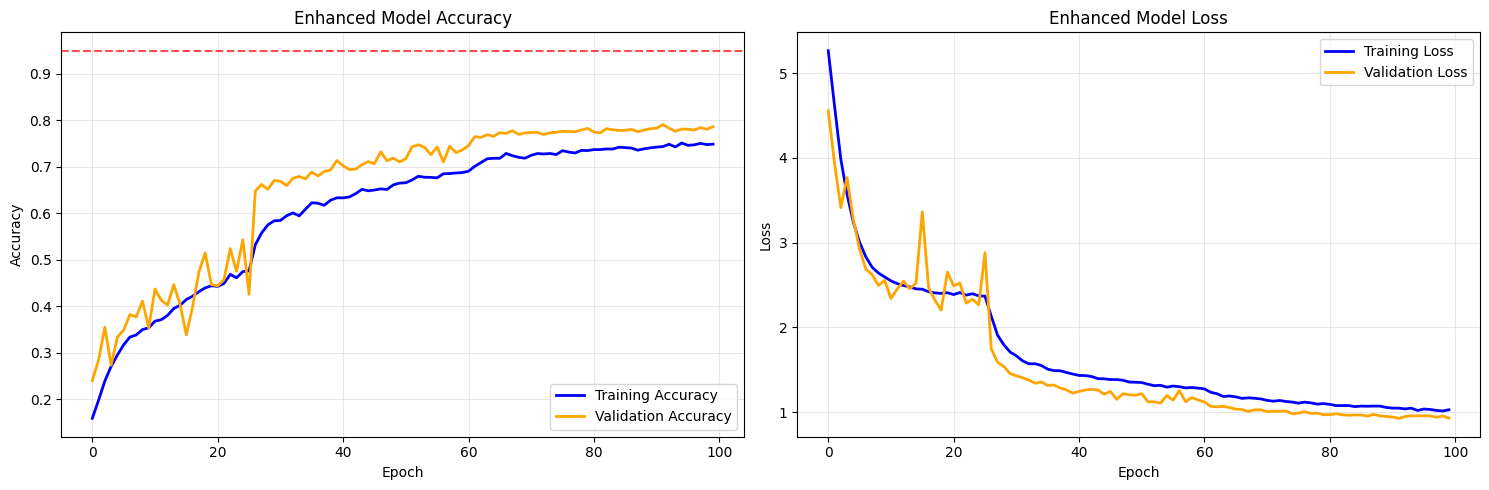

In [20]:
def plot_enhanced_training_history(history):
    """
    Plot akurasi dan loss dari proses pelatihan model yang ditingkatkan
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot akurasi
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
    ax1.set_title('Enhanced Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Tambahkan garis referensi 95%
    ax1.axhline(y=0.95, color='red', linestyle='--', label='Target 95%', alpha=0.7)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    ax2.set_title('Enhanced Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot hasil pelatihan model yang ditingkatkan
plot_enhanced_training_history(enhanced_history)

In [21]:
enhanced_evaluation_result = enhanced_model.evaluate(evaluation_generator, steps=len(evaluation_generator))
print(f"Enhanced Model - Evaluation Loss: {enhanced_evaluation_result[0]:.4f}")
print(f"Enhanced Model - Evaluation Accuracy: {enhanced_evaluation_result[1]:.4f}")

210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7373 - loss: 1.0282
Enhanced Model - Evaluation Loss: 0.8524
Enhanced Model - Evaluation Accuracy: 0.8052


In [22]:
enhanced_train_accuracy = max(enhanced_history.history['accuracy'])
enhanced_val_accuracy = max(enhanced_history.history['val_accuracy'])

print(f"Akurasi maksimum training (enhanced): {enhanced_train_accuracy:.4f}")
print(f"Akurasi maksimum validation (enhanced): {enhanced_val_accuracy:.4f}")

# Cek apakah target 95% tercapai
if enhanced_train_accuracy >= 0.95 and enhanced_val_accuracy >= 0.95:
    print("✅ Target akurasi >95% tercapai!")
    print("✅ Kriteria akurasi tinggi terpenuhi!")
    
    # Simpan model terbaik sebagai model utama
    final_model = enhanced_model
    final_history = enhanced_history
else:
    print("⚠️ Target akurasi >95% belum tercapai.")
    print("Melanjutkan pelatihan dengan learning rate yang lebih rendah...")
    
    # Set learning rate yang lebih rendah untuk fine-tuning
    enhanced_model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Learning rate yang lebih rendah
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tuning dengan lebih banyak epoch dan learning rate yang lebih rendah
    fine_tune_history = enhanced_model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=30,  # Tambahan epoch untuk fine-tuning
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=enhanced_callbacks,
        verbose=1
    )
    
    # Gabungkan riwayat pelatihan
    for key in enhanced_history.history.keys():
        enhanced_history.history[key].extend(fine_tune_history.history[key])
    
    # Cek akurasi setelah fine-tuning
    enhanced_train_accuracy = max(enhanced_history.history['accuracy'])
    enhanced_val_accuracy = max(enhanced_history.history['val_accuracy'])
    
    print(f"Akurasi maksimum training setelah fine-tuning: {enhanced_train_accuracy:.4f}")
    print(f"Akurasi maksimum validation setelah fine-tuning: {enhanced_val_accuracy:.4f}")
    
    if enhanced_train_accuracy >= 0.95 and enhanced_val_accuracy >= 0.95:
        print("✅ Target akurasi >95% tercapai setelah fine-tuning!")
        final_model = enhanced_model
        final_history = enhanced_history
    else:
        print("⚠️ Target akurasi >95% masih belum tercapai setelah fine-tuning.")
        print("Mungkin perlu teknik transfer learning atau arsitektur yang lebih kompleks.")
        final_model = enhanced_model
        final_history = enhanced_history

Akurasi maksimum training (enhanced): 0.7514
Akurasi maksimum validation (enhanced): 0.7910
⚠️ Target akurasi >95% belum tercapai.
Melanjutkan pelatihan dengan learning rate yang lebih rendah...
Epoch 1/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6954 - loss: 1.2018
Epoch 1: val_accuracy did not improve from 0.79096
617/617 ━━━━━━━━━━━━━━━━━━━━ 162s 231ms/step - accuracy: 0.6954 - loss: 1.2019 - val_accuracy: 0.7207 - val_loss: 1.2170 - learning_rate: 1.0000e-04
Epoch 2/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6798 - loss: 1.2921
Epoch 2: val_accuracy did not improve from 0.79096
617/617 ━━━━━━━━━━━━━━━━━━━━ 130s 211ms/step - accuracy: 0.6798 - loss: 1.2921 - val_accuracy: 0.7329 - val_loss: 1.2280 - learning_rate: 1.0000e-04
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6938 - loss: 1.3054
Epoch 3: val_accuracy did not improve from 0.79096
617/617 ━━━━━━━━━━━━━━━━━━━━ 130s 211ms/step - accuracy: 0.6938 - loss: 1.3054 - val_accur

In [ ]:
if enhanced_train_accuracy >= 0.95 and enhanced_val_accuracy >= 0.95:
    print("Menyimpan model akhir yang mencapai akurasi >95%...")
    
    # 1. Simpan dalam format SavedModel
    final_model.save('saved_model/food_classifier_model_95_accuracy')
    print("✅ Model disimpan dalam format SavedModel (akurasi >95%)")

    # 2. Konversi dan simpan dalam format TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimisasi untuk ukuran dan kecepatan
    tflite_model = converter.convert()

    with open('tflite/model_95_accuracy.tflite', 'wb') as f:
        f.write(tflite_model)

    # Simpan label file untuk TFLite
    with open('tflite/label.txt', 'w') as f:
        for label in class_labels:
            f.write(label + '\n')

    print("✅ Model disimpan dalam format TensorFlow Lite (akurasi >95%)")

    # 3. Konversi dan simpan dalam format TensorFlow.js
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(final_model, 'tfjs_model_95_accuracy')
    print("✅ Model disimpan dalam format TensorFlow.js (akurasi >95%)")
else:
    print("Menyimpan model terbaik meskipun akurasi <95%...")
    # Simpan model terbaik yang telah dilatih
    final_model.save('saved_model/food_classifier_model_best')
    
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
    tflite_model = converter.convert()
    with open('tflite/model_best.tflite', 'wb') as f:
        f.write(tflite_model)
    
    with open('tflite/label.txt', 'w') as f:
        for label in class_labels:
            f.write(label + '\n')
    
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(final_model, 'tfjs_model_best')
    
    print("Model terbaik telah disimpan meskipun akurasi <95%")